In [33]:
import os
import sys
# from Bio import SeqIO
import pickle
import numpy as np
import pandas as pd

# import tensorflow as tf
# import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import math

In [35]:
import sklearn
sklearn.__version__

'0.21.3'

In [2]:
##################################################################################
##### Define all experiment parameters
##################################################################################

expName = "MathFeature_setting1"
outPath = "Generated"

dataset_path = "Datasets"
setting = "Setting1"
output_path = "Results_RF_SVM"

datafile_extensions = ".csv"

## changes needed to model_generator function as well, add/remove else_if conditions
modelNames = ["RandomForest", "SVM"]

shuffle = False
seed = 123

##################################################################################
##### Define the modelling hyperparameters
##################################################################################

n_fold = 5


In [3]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(outPath, expName, dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
result_output_path = os.path.join(outPath, expName, output_path, setting)

In [4]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

def model_generator(modelName):
    model = None
    if modelName == "RandomForest":
        model = RandomForestClassifier(n_estimators=100, 
                                       criterion='gini', 
                                       bootstrap=True, 
                                       oob_score=True)
    elif modelName == "SVM":
        model = SVC(C = 1,
                    kernel = "rbf",
                    gamma = "scale", # only for rbf/poly/sigmoid
                    max_iter = -1)
    return model

In [28]:
feature = np.array([1,2,3,4,5,6,7,8,9,10]).reshape(10,1)
label = np.array([1,1,1,1,1,0,0,0,0,0]).reshape(10,1)
k = 5

In [29]:
test = build_kfold(feature, label, k=5)

In [31]:
for fold in test:
    print(fold)

{'X_train': array([[ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 7],
       [ 8],
       [ 9],
       [10]]), 'X_test': array([[1],
       [6]]), 'y_train': array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]]), 'y_test': array([[1],
       [0]])}
{'X_train': array([[ 1],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 8],
       [ 9],
       [10]]), 'X_test': array([[2],
       [7]]), 'y_train': array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]]), 'y_test': array([[1],
       [0]])}
{'X_train': array([[ 1],
       [ 2],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 9],
       [10]]), 'X_test': array([[3],
       [8]]), 'y_train': array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]]), 'y_test': array([[1],
       [0]])}
{'X_train': array([[ 1],
       [ 2],
       [ 3],
       [ 5],
       [ 6],
       [ 7],
       [ 8],


In [5]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

error_list = []

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Encoding_Type" : [],
    "Dataset" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        if os.path.splitext(file)[-1] == datafile_extensions:
            
            try:
                current_dataset_variety = root.split("\\")[len(root.split("\\"))-1]
                encoding_type = file.split(".")[0].split("_")[-1]

                ##################################################################################
                ##### read the current file
                ##################################################################################

                input_file_full_path = os.path.join(root, file)

                ## check if input file has header
                file_obj = open(input_file_full_path, "r")
                first_line = file_obj.readline()
                file_obj.close()
                file_has_header = None
                if first_line.split(",")[0] == "nameseq" or first_line.replace("\n", "").split(",")[-1] == "label":
                    file_has_header = 1
                    
                sequences_df = pd.read_csv(input_file_full_path, header = file_has_header)

                ##################################################################################
                ##### extract data from the current dataframe file
                ##################################################################################

                sequences_df["class"] = np.where(sequences_df[sequences_df.columns[0]].str.contains("nucleosomal"), 1, 0)

                print("\n======================================================================")
                print("\nFile: "+os.path.join(root, file))
                print("Nucleosomi: "+str(sum(sequences_df["class"])))
                print("Linker: "+str(len(sequences_df) - sum(sequences_df["class"])))

                ##################################################################################
                ##### Generate Folds from dataset, and store to file
                ##################################################################################

                ## create the features and labels datasets for the training
                labels = np.array(sequences_df["class"])
                features = sequences_df.drop(sequences_df.columns[0], axis = 1).drop(sequences_df.columns[-1], axis = 1).drop(sequences_df.columns[-2], axis = 1).values
                features = features.astype(np.float)

                ## Parameters to Read/Write the k-fold dataset to file
                foldPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold))
                foldName = file.split(".")[0]+"_{}fold".format(n_fold)+".pickle"

                ##### USE PREVIOUS GENERATED FOLDS IF AVAILABLE, else generate and store folds
                if(os.path.isfile(os.path.join(foldPath, foldName))):
                    folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
                else:
                    ## Generate the k-fold dataset
                    folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
                    if(not os.path.isdir(foldPath)):
                        os.makedirs(foldPath)
                    pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

                for modelName in modelNames:
                    
                    ## Create and set directory to save model
                    modelPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
                    if(not os.path.isdir(modelPath)):
                        os.makedirs(modelPath)

                    ## fold counter
                    i = 0

                    for fold in folds:

                        print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")
                        
                        ## Generate model using function
                        model = model_generator(modelName)

                        model.fit(X = fold["X_train"], y = fold["y_train"])

                        model_filename = "{}_fold{}_model.pickle".format(encoding_type, i)

                        model_file_obj = open(os.path.join(modelPath, model_filename), 'wb')
                        pickle.dump(model, model_file_obj)
                        model_file_obj.close()

                        ##################################################################################
                        ##### Prediction and metrics for TRAIN dataset
                        ##################################################################################

                        y_pred = model.predict(fold["X_train"])
                        label_pred = pred2label(y_pred)
                        # Compute precision, recall, sensitivity, specifity, mcc
                        acc = accuracy_score(fold["y_train"], label_pred)
                        prec = precision_score(fold["y_train"],label_pred)

                        conf = confusion_matrix(fold["y_train"], label_pred)
                        if(conf[0][0]+conf[1][0]):
                            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                        else:
                            sens = 0.0
                        if(conf[1][1]+conf[0][1]):
                            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                        else:
                            spec = 0.0
                        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                        else:
                            mcc= 0.0
                        fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                        auc = roc_auc_score(fold["y_train"], y_pred)

                        evaluations["Model"].append(modelName)
                        evaluations["Encoding_Type"].append(encoding_type)
                        evaluations["Dataset"].append(current_dataset_variety)
                        evaluations["Fold"].append(i)
                        evaluations["Train_Test"].append("Train")
                        evaluations["Accuracy"].append(acc)
                        evaluations["Precision"].append(prec)
                        evaluations["TPR"].append(tpr)
                        evaluations["FPR"].append(fpr)
                        evaluations["TPR_FPR_Thresholds"].append(thresholds)
                        evaluations["AUC"].append(auc)
                        evaluations["Sensitivity"].append(sens)
                        evaluations["Specificity"].append(spec)
                        evaluations["MCC"].append(mcc)

                        ##################################################################################
                        ##### Prediction and metrics for TEST dataset
                        ##################################################################################

                        y_pred = model.predict(fold["X_test"])
                        label_pred = pred2label(y_pred)
                        # Compute precision, recall, sensitivity, specifity, mcc
                        acc = accuracy_score(fold["y_test"], label_pred)
                        prec = precision_score(fold["y_test"],label_pred)

                        conf = confusion_matrix(fold["y_test"], label_pred)
                        if(conf[0][0]+conf[1][0]):
                            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                        else:
                            sens = 0.0
                        if(conf[1][1]+conf[0][1]):
                            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                        else:
                            spec = 0.0
                        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                        else:
                            mcc= 0.0
                        fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                        auc = roc_auc_score(fold["y_test"], y_pred)

                        evaluations["Model"].append(modelName)
                        evaluations["Encoding_Type"].append(encoding_type)
                        evaluations["Dataset"].append(current_dataset_variety)
                        evaluations["Fold"].append(i)
                        evaluations["Train_Test"].append("Test")
                        evaluations["Accuracy"].append(acc)
                        evaluations["Precision"].append(prec)
                        evaluations["TPR"].append(tpr)
                        evaluations["FPR"].append(fpr)
                        evaluations["TPR_FPR_Thresholds"].append(thresholds)
                        evaluations["AUC"].append(auc)
                        evaluations["Sensitivity"].append(sens)
                        evaluations["Specificity"].append(spec)
                        evaluations["MCC"].append(mcc)

                        i = i+1
                        
            except Exception as error:
                error_list.append((input_file_full_path, error))
                
##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(result_output_path, "_Evaluation_All_Datasets", "{}fold".format(n_fold))
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "wb"))

##################################################################################
##### Dump exceptions to a file
##################################################################################

pickle.dump(error_list,
            open(os.path.join(result_output_path, "{}fold_exceptions.pickle".format(n_fold)), "wb"))




File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_ANF.csv
Nucleosomi: 2900
Linker: 2850

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_ANFF.csv
Nucleosomi: 2899
Linker: 2850

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test m


Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_kstep.csv
Nucleosomi: 2899
Linker: 2850

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_lin


Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_NMFT-real.csv
Nucleosomi: 2899
Linker: 2850

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_NMFT-zcurve.csv
Nucleosomi: 2899
Linker: 2850

Train/Test model RandomForest on Fold #0.

Train/Test model 


Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Elegans\nucleosomes_vs_linkers_elegans_Entropy-shannon.csv
Nucleosomi: 2566
Linker: 2608

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Elegans\nucleosomes_vs_linkers_elegans_Entropy-tsallis.csv
Nucleosomi: 2566
Linker: 2608

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train


Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Elegans\nucleosomes_vs_linkers_elegans_NMFT-atomic.csv
Nucleosomi: 2566
Linker: 2608

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Elegans\nucleosomes_vs_linkers_elegans_NMFT-binary.csv
Nucleosomi: 2566
Li


Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_Chaos-frequency-signal.csv
Nucleosomi: 2272
Linker: 2300

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_Chaos-frequenc


Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_NM-binary.csv
Nucleosomi: 2273
Linker: 2300

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_NM-complex.csv
Nucleosomi: 2273
Linker: 2300


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_NM-eiip.cs

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_NMFT-binary.csv
Nucleosomi: 2272
Linker: 2300

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens_NMFT-complex.csv
Nucleosomi: 2272
Linker: 2300

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test 


Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Yeast\nucleosomes_vs_linkers_yeast_Complex-Network-v2.csv
Nucleosomi: 1879
Linker: 1740

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Yeast\nucleosomes_vs_linkers_yeast_Complex-Network.csv
Nucleosomi: 1879


Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Yeast\nucleosomes_vs_linkers_yeast_NM-integer.csv
Nucleosomi: 1880
Linker: 1740

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model SVM on Fold #0.

Train/Test model SVM on Fold #1.

Train/Test model SVM on Fold #2.

Train/Test model SVM on Fold #3.

Train/Test model SVM on Fold #4.


File: Generated\MathFeature_setting1\Datasets\Setting1\Yeast\nucleosomes_vs_linkers_yeast_NM-real.csv
Nucleosomi: 1880
Linker: 1740

Train/Test model RandomForest on Fold #0.

T

In [6]:
error_list

[('Generated\\MathFeature_setting1\\Datasets\\Setting1\\Drosophila\\nucleosomes_vs_linkers_melanogaster_Complex-Network.csv',
  ValueError("Input contains NaN, infinity or a value too large for dtype('float32').")),
 ('Generated\\MathFeature_setting1\\Datasets\\Setting1\\Drosophila\\nucleosomes_vs_linkers_melanogaster_NM-complex.csv',
  ValueError("could not convert string to float: '(-1-1j)'")),
 ('Generated\\MathFeature_setting1\\Datasets\\Setting1\\Elegans\\nucleosomes_vs_linkers_elegans_Complex-Network.csv',
  ValueError("Input contains NaN, infinity or a value too large for dtype('float32').")),
 ('Generated\\MathFeature_setting1\\Datasets\\Setting1\\Elegans\\nucleosomes_vs_linkers_elegans_NM-complex.csv',
  ValueError("could not convert string to float: '(-1-1j)'")),
 ('Generated\\MathFeature_setting1\\Datasets\\Setting1\\Homo_Sapiens\\nucleosomes_vs_linkers_sapiens_Complex-Network.csv',
  ValueError("Input contains NaN, infinity or a value too large for dtype('float32').")),
 ('

## Visualization of Evaluation

In [37]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd


In [38]:
##################################################################################
##### Parameters used only in this section
##################################################################################

n_fold = 5

expName = "MathFeature_setting1"
outPath = "Generated"
setting = "Setting1"
output_path = "Results_RF_SVM"

# modelNames = ["RandomForest"]

In [39]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, output_path, setting, "_Evaluation_All_Datasets", "{}fold".format(n_fold))

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [40]:
evaluations_df

,Model,Encoding_Type,Dataset,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,RandomForest,ANF,Drosophila,0,Train,0.999783,0.999569,"[0.0, 1.0, 1.0]","[0.0, 0.0004385964912280702, 1.0]","[2, 1, 0]",0.999781,1.000000,0.999569,0.999565
1,RandomForest,ANF,Drosophila,0,Test,0.647826,0.752161,"[0.0, 0.45, 1.0]","[0.0, 0.15087719298245614, 1.0]","[2, 1, 0]",0.649561,0.602740,0.752161,0.325821
2,RandomForest,ANF,Drosophila,1,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
3,RandomForest,ANF,Drosophila,1,Test,0.709565,0.779545,"[0.0, 0.5913793103448276, 1.0]","[0.0, 0.17017543859649123, 1.0]","[2, 1, 0]",0.710602,0.666197,0.779545,0.433300
4,RandomForest,ANF,Drosophila,2,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,SVM,TNC,Yeast,2,Test,0.998619,0.997347,"[0.0, 1.0, 1.0]","[0.0, 0.0028735632183908046, 1.0]","[2, 1, 0]",0.998563,1.000000,0.997347,0.997237
2536,SVM,TNC,Yeast,3,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
2537,SVM,TNC,Yeast,3,Test,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
2538,SVM,TNC,Yeast,4,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000


In [41]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset",
                                                 "Encoding_Type",
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

# Eval_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Train'])]
# Eval_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Test'])]

datasets = np.unique(evaluations_df_grouped.index.get_level_values(0))
models = np.unique(evaluations_df_grouped.index.get_level_values(2))

In [42]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ", list(evaluations_df_grouped.columns))
print("Datasets Available : ", list(datasets))
print("Models Available : ", list(models))

Metrics Available :  ['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']
Datasets Available :  ['Drosophila', 'Elegans', 'Homo_Sapiens', 'Yeast']
Models Available :  ['RandomForest', 'SVM']


#### Select a metric to plot below:

In [43]:
metric_to_plot = "Accuracy"
dataset_to_print = "Drosophila"
model = "RandomForest"

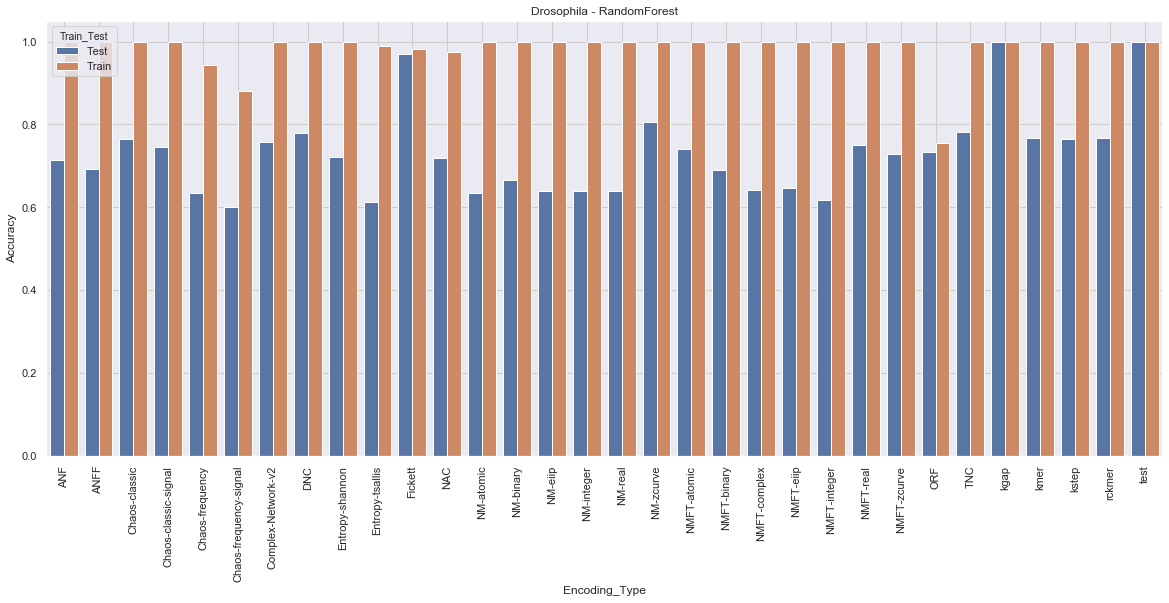

In [44]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
df = df[np.in1d(df.index.get_level_values(2), [model])]
df = df.reset_index(level=['Encoding_Type', 'Train_Test'])

# Some boilerplate to initialise things
sns.set()
plt.figure(figsize=(20,8))

# This is where the actual plot gets made
ax = sns.barplot(data=df, x="Encoding_Type", y=metric_to_plot, hue="Train_Test")

# Customise some display properties
ax.set_title(dataset_to_print+" - "+model)
ax.grid(color='#cccccc')
ax.set_ylabel(metric_to_plot)
ax.set_xlabel("Encoding_Type")
ax.set_xticklabels(df["Encoding_Type"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.show()

### Store all metrics' plots to file

In [45]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    for dataset_to_print in datasets:
        for model in models:
    
            df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
            df = df[np.in1d(df.index.get_level_values(2), [model])]
            df = df.reset_index(level=['Encoding_Type', 'Train_Test'])

            # Some boilerplate to initialise things
            sns.set()
            plt.figure(figsize=(20,8))

            # This is where the actual plot gets made
            ax = sns.barplot(data=df, x="Encoding_Type", y=metric_to_plot, hue="Train_Test")

            # Customise some display properties
            ax.set_title(dataset_to_print+" - "+model)
            ax.grid(color='#cccccc')
            ax.set_ylabel(metric_to_plot)
            ax.set_xlabel("Encoding_Type")
            ax.set_xticklabels(df["Encoding_Type"].unique().astype(str), rotation='vertical')

            plt.savefig(os.path.join(evalPath, "{}_{}_{}_Comparison".format(metric_to_plot, dataset_to_print, model)))
            plt.close()


In [46]:
evalPath

'Generated\\MathFeature_setting1\\Results_RF_SVM\\Setting1\\_Evaluation_All_Datasets\\5fold'